# Inspection

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

# Your data paths
BASE_DIR = Path('/Users/haileyreed/Desktop/Honors_Thesis')
PROCESSED_DIR = BASE_DIR / 'Processed_Datasets'

# Output directory for patches
PATCHES_DIR = BASE_DIR / 'Patches'
PATCHES_DIR.mkdir(exist_ok=True)

In [22]:
from collections import Counter

print("COLOR ANALYSIS - Before Quantization")

def count_colors(image_path):
    """
    Count unique colors in an image.
    
    Args:
        image_path: Path to image file
    
    Returns:
        Counter object with color frequencies
    """
    # Open image and convert to RGB
    img = Image.open(image_path).convert("RGB")
    
    # Get pixel data as a list
    pixels = list(img.getdata())
    
    # Count the frequency of each color
    color_counts = Counter(pixels)
    
    print(f"  Total unique colors: {len(color_counts):,}")
    print(f"  Top 10 most frequent colors:")
    for color, count in color_counts.most_common(10):
        print(f"    RGB{color}: {count:,} pixels ({count/len(pixels)*100:.2f}%)")
    
    return color_counts

# Analyze sample images from each dataset
datasets = {
    'MoNuSeg': PROCESSED_DIR / 'MoNuSeg' / 'train' / 'images',
    'GlaS': PROCESSED_DIR / 'GlaS' / 'train' / 'images',
    'TNBC': PROCESSED_DIR / 'TNBC' / 'train' / 'images'
}

for dataset_name, image_dir in datasets.items():
    print(f"\n{'='*60}")
    print(f"{dataset_name} Dataset - Color Analysis")
    print(f"{'='*60}")
    
    # Get first 3 sample images
    image_files = sorted(list(image_dir.glob('*.png')))[:3]
    
    if len(image_files) == 0:
        print(f"  No images found in {image_dir}")
        continue
    
    for idx, img_path in enumerate(image_files, 1):
        print(f"\nSample {idx}: {img_path.name}")
        color_counts = count_colors(img_path)
        
        # Show color richness
        total_pixels = sum(color_counts.values())
        color_richness = len(color_counts) / total_pixels
        print(f"  Color richness: {color_richness:.6f} (unique colors per pixel)")

print("\n" + "="*60)
print("After quantization, each image will have only 3 unique colors")
print("="*60)

COLOR ANALYSIS - Before Quantization

MoNuSeg Dataset - Color Analysis

Sample 1: TCGA-18-5592-01Z-00-DX1.png
  Total unique colors: 73,268
  Top 10 most frequent colors:
    RGB(189, 93, 131): 656 pixels (0.07%)
    RGB(187, 92, 130): 652 pixels (0.07%)
    RGB(190, 94, 132): 648 pixels (0.06%)
    RGB(192, 96, 133): 640 pixels (0.06%)
    RGB(189, 94, 132): 638 pixels (0.06%)
    RGB(188, 92, 130): 629 pixels (0.06%)
    RGB(191, 95, 132): 624 pixels (0.06%)
    RGB(188, 93, 131): 621 pixels (0.06%)
    RGB(191, 95, 133): 619 pixels (0.06%)
    RGB(191, 96, 134): 614 pixels (0.06%)
  Color richness: 0.073268 (unique colors per pixel)

Sample 2: TCGA-21-5784-01Z-00-DX1.png
  Total unique colors: 350,389
  Top 10 most frequent colors:
    RGB(239, 236, 239): 14,691 pixels (1.47%)
    RGB(243, 236, 239): 6,058 pixels (0.61%)
    RGB(239, 239, 239): 3,954 pixels (0.40%)
    RGB(243, 239, 239): 3,640 pixels (0.36%)
    RGB(239, 235, 239): 851 pixels (0.09%)
    RGB(239, 233, 239): 814 pix

# K-Means Quantization

In [13]:
def apply_kmeans_quantization(image, n_colors=3, random_state=0):
    """
    Apply K-means color quantization to create low-fidelity version.
    
    Args:
        image: RGB image as numpy array (0-255)
        n_colors: Number of colors for quantization
        random_state: Random seed for reproducibility
    
    Returns:
        Quantized image as numpy array (0-255)
    """
    # ensure RGB [datasets may contain RGBA, alpha will kill k-means]
    if isinstance(image, Image.Image):
        image = image.convert("RGB")
    
    # Cases: Grayscale & RGBA --> ensure 3 channels
    if len(image.shape) == 2:
        # grayscale - convert to RGB by stacking
        image = np.stack([image, image, image], axis=-1)
    elif image.shape[2] == 4:
        # RGBA - drop alpha channel
        image = image[:, :, :3]

    # normalize to [0, 1]
    image = np.array(image, dtype=np.float64) / 255

    # reshape to 2D array of pixels --> K-Means expects 2D array
    w, h, d = image.shape
    assert d == 3
    image_array = np.reshape(image, (w * h, d))

    # create image array sample --> we will fit K-Means to this random sample
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
    
    # fit Kmeans to sample
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(image_array_sample)
    
    # predict on full image
    labels = kmeans.predict(image_array)
    
    # Recreate image with cluster centers
    quantized = kmeans.cluster_centers_[labels]
    quantized = quantized.reshape(h, w, d)
    
    # Convert back to [0, 255]
    return (quantized * 255).astype(np.uint8)

In [14]:
def extract_patches(img_high, img_low, mask, patch_size=128, stride=128, pad_mode='reflect'):
    """
    Extract aligned patches from high-fidelity, low-fidelity, and mask images.
    
    Args:
        img_high: High-fidelity RGB image (H, W, 3)
        img_low: Low-fidelity RGB image (H, W, 3)
        mask: Binary mask (H, W)
        patch_size: Size of square patches
        stride: Stride for sliding window
        pad_mode: Padding mode ('reflect', 'replicate', 'constant')
    
    Returns:
        List of dictionaries with keys: 'high', 'low', 'mask'
    """
    def pad_to_multiple(img, patch_size, mode='reflect'):
        """Pad image to be divisible by patch_size."""
        h, w = img.shape[:2]
        pad_h = (patch_size - h % patch_size) % patch_size
        pad_w = (patch_size - w % patch_size) % patch_size
        
        if pad_h == 0 and pad_w == 0:
            return img
        
        border_map = {
            'reflect': cv2.BORDER_REFLECT,
            'replicate': cv2.BORDER_REPLICATE,
            'constant': cv2.BORDER_CONSTANT
        }
        border = border_map.get(mode, cv2.BORDER_REFLECT)
        
        if len(img.shape) == 2:  # Grayscale
            return cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, borderType=border)
        else:  # Color
            return cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, borderType=border)
    
    # Pad all images
    img_high_pad = pad_to_multiple(img_high, patch_size, pad_mode)
    img_low_pad = pad_to_multiple(img_low, patch_size, pad_mode)
    mask_pad = pad_to_multiple(mask, patch_size, pad_mode)
    
    H, W = img_high_pad.shape[:2]
    
    # Extract patches
    patches = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_high = img_high_pad[y:y+patch_size, x:x+patch_size]
            patch_low = img_low_pad[y:y+patch_size, x:x+patch_size]
            patch_mask = mask_pad[y:y+patch_size, x:x+patch_size]
            
            patches.append({
                'high': patch_high,
                'low': patch_low,
                'mask': patch_mask
            })
    
    return patches

print("Patch extraction function ready!")

Patch extraction function ready!


In [15]:
def preprocess_dataset(dataset_name, image_dir, mask_dir, output_dir, 
                       split='train', target_size=1024, patch_size=128, 
                       stride=128, n_colors=3):
    """
    Complete preprocessing pipeline for one dataset split.
    
    Steps:
        1. Resize images to target_size x target_size
        2. Create low-fidelity version via K-means quantization
        3. Extract patches from both versions + mask
        4. Save patches
    """
    output_dir = Path(output_dir)
    output_high = output_dir / f'{dataset_name}_{split}_high'
    output_low = output_dir / f'{dataset_name}_{split}_low'
    output_mask = output_dir / f'{dataset_name}_{split}_mask'
    
    for d in [output_high, output_low, output_mask]:
        d.mkdir(parents=True, exist_ok=True)
    
    image_files = sorted(list(Path(image_dir).glob('*.png')))
    patch_counter = 0
    
    print(f"\n{'='*60}")
    print(f"Preprocessing {dataset_name} - {split}")
    print(f"{'='*60}")
    
    for idx, img_path in enumerate(image_files):
        # Load image and mask
        img_high = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img_high = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
        
        mask_path = Path(mask_dir) / img_path.name
        if not mask_path.exists():
            print(f"[SKIP] No mask for {img_path.name}")
            continue
        
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Resize to target size
        img_high = cv2.resize(img_high, (target_size, target_size), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
        
        # Create low-fidelity version via K-means quantization
        img_low = apply_kmeans_quantization(img_high, n_colors=n_colors)
        
        # Extract patches
        patches = extract_patches(img_high, img_low, mask, patch_size=patch_size, stride=stride)
        
        # Save patches
        for patch in patches:
            patch_name = f"{patch_counter:06d}.png"
            
            # Save as RGB
            cv2.imwrite(str(output_high / patch_name), cv2.cvtColor(patch['high'], cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(output_low / patch_name), cv2.cvtColor(patch['low'], cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(output_mask / patch_name), patch['mask'])
            
            patch_counter += 1
        
        if (idx + 1) % 5 == 0:
            print(f"  Processed {idx+1}/{len(image_files)} images, {patch_counter} patches")
    
    print(f"\n✓ {dataset_name} {split}: {len(image_files)} images → {patch_counter} patches")
    print(f"  Output: {output_dir / dataset_name}_{split}_*")
    
    return patch_counter

### MoNuSeg

In [16]:
# Process MoNuSeg
monuseg_train_patches = preprocess_dataset(
    dataset_name='MoNuSeg',
    image_dir=PROCESSED_DIR / 'MoNuSeg' / 'train' / 'images',
    mask_dir=PROCESSED_DIR / 'MoNuSeg' / 'train' / 'masks',
    output_dir=PATCHES_DIR,
    split='train',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)

monuseg_test_patches = preprocess_dataset(
    dataset_name='MoNuSeg',
    image_dir=PROCESSED_DIR / 'MoNuSeg' / 'test' / 'images',
    mask_dir=PROCESSED_DIR / 'MoNuSeg' / 'test' / 'masks',
    output_dir=PATCHES_DIR,
    split='test',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)


Preprocessing MoNuSeg - train


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/37 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/37 images, 640 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 15/37 images, 960 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 20/37 images, 1280 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 25/37 images, 1600 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 30/37 images, 1920 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 35/37 images, 2240 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_


✓ MoNuSeg train: 37 images → 2368 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/MoNuSeg_train_*

Preprocessing MoNuSeg - test


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/14 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/14 images, 640 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_


✓ MoNuSeg test: 14 images → 896 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/MoNuSeg_test_*


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

### Glas

In [17]:
# Process GlaS
glas_train_patches = preprocess_dataset(
    dataset_name='GlaS',
    image_dir=PROCESSED_DIR / 'GlaS' / 'train' / 'images',
    mask_dir=PROCESSED_DIR / 'GlaS' / 'train' / 'masks',
    output_dir=PATCHES_DIR,
    split='train',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)

glas_test_patches = preprocess_dataset(
    dataset_name='GlaS',
    image_dir=PROCESSED_DIR / 'GlaS' / 'test' / 'images',
    mask_dir=PROCESSED_DIR / 'GlaS' / 'test' / 'masks',
    output_dir=PATCHES_DIR,
    split='test',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)


Preprocessing GlaS - train


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/85 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/85 images, 640 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 15/85 images, 960 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 20/85 images, 1280 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 25/85 images, 1600 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 30/85 images, 1920 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 35/85 images, 2240 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 40/85 images, 2560 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 45/85 images, 2880 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 50/85 images, 3200 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 55/85 images, 3520 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 60/85 images, 3840 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 65/85 images, 4160 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 70/85 images, 4480 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 75/85 images, 4800 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 80/85 images, 5120 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 85/85 images, 5440 patches

✓ GlaS train: 85 images → 5440 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/GlaS_train_*

Preprocessing GlaS - test


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/80 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/80 images, 640 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 15/80 images, 960 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 20/80 images, 1280 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 25/80 images, 1600 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 30/80 images, 1920 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 35/80 images, 2240 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 40/80 images, 2560 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 45/80 images, 2880 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 50/80 images, 3200 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 55/80 images, 3520 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 60/80 images, 3840 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 65/80 images, 4160 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 70/80 images, 4480 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 75/80 images, 4800 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 80/80 images, 5120 patches

✓ GlaS test: 80 images → 5120 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/GlaS_test_*


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

### TNBC

In [18]:
# Process TNBC
tnbc_train_patches = preprocess_dataset(
    dataset_name='TNBC',
    image_dir=PROCESSED_DIR / 'TNBC' / 'train' / 'images',
    mask_dir=PROCESSED_DIR / 'TNBC' / 'train' / 'masks',
    output_dir=PATCHES_DIR,
    split='train',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)

tnbc_test_patches = preprocess_dataset(
    dataset_name='TNBC',
    image_dir=PROCESSED_DIR / 'TNBC' / 'test' / 'images',
    mask_dir=PROCESSED_DIR / 'TNBC' / 'test' / 'masks',
    output_dir=PATCHES_DIR,
    split='test',
    target_size=1024,
    patch_size=128,
    stride=128,
    n_colors=3
)

/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_


Preprocessing TNBC - train


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/37 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/37 images, 640 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 15/37 images, 960 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 20/37 images, 1280 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 25/37 images, 1600 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 30/37 images, 1920 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 35/37 images, 2240 patches

✓ TNBC train: 37 images → 2368 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/TNBC_train_*

Preprocessing TNBC - test


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 5/13 images, 320 patches


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

  Processed 10/13 images, 640 patches

✓ TNBC test: 13 images → 832 patches
  Output: /Users/haileyreed/Desktop/Honors_Thesis/Patches/TNBC_test_*


/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/opt/anaconda3/envs/livae313/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:243: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

## Visualize

PATCH VISUALIZATION


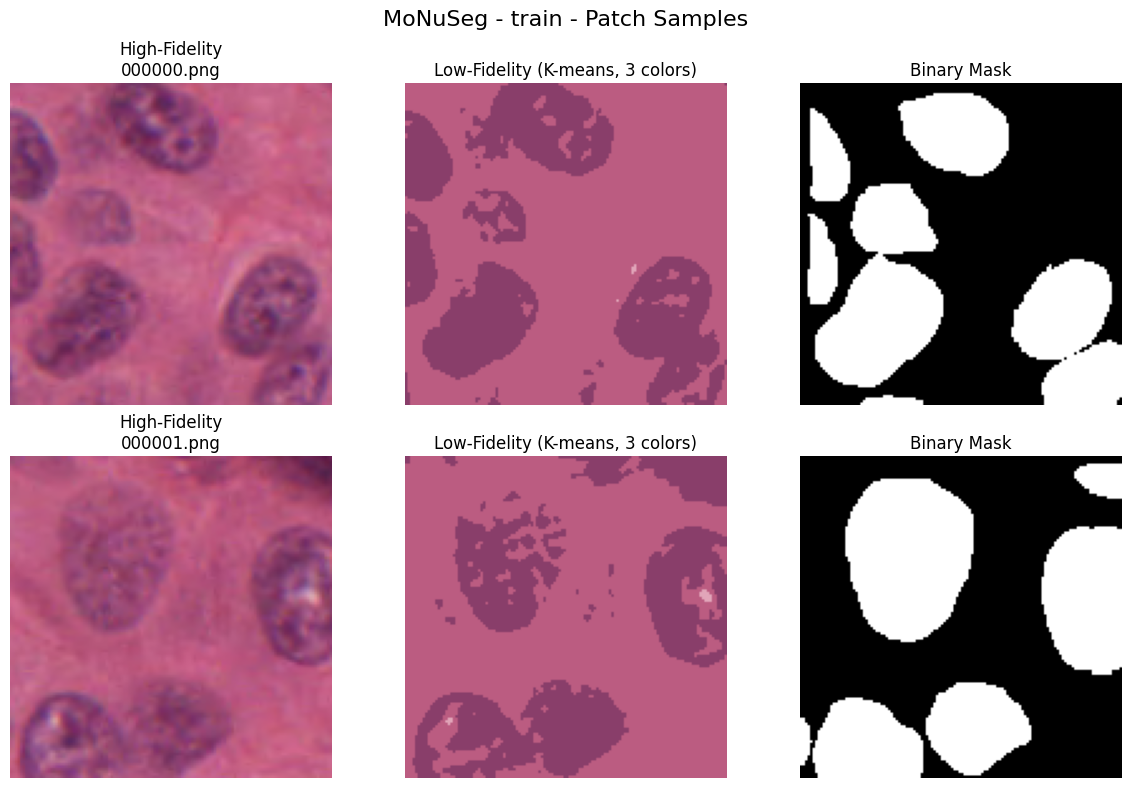

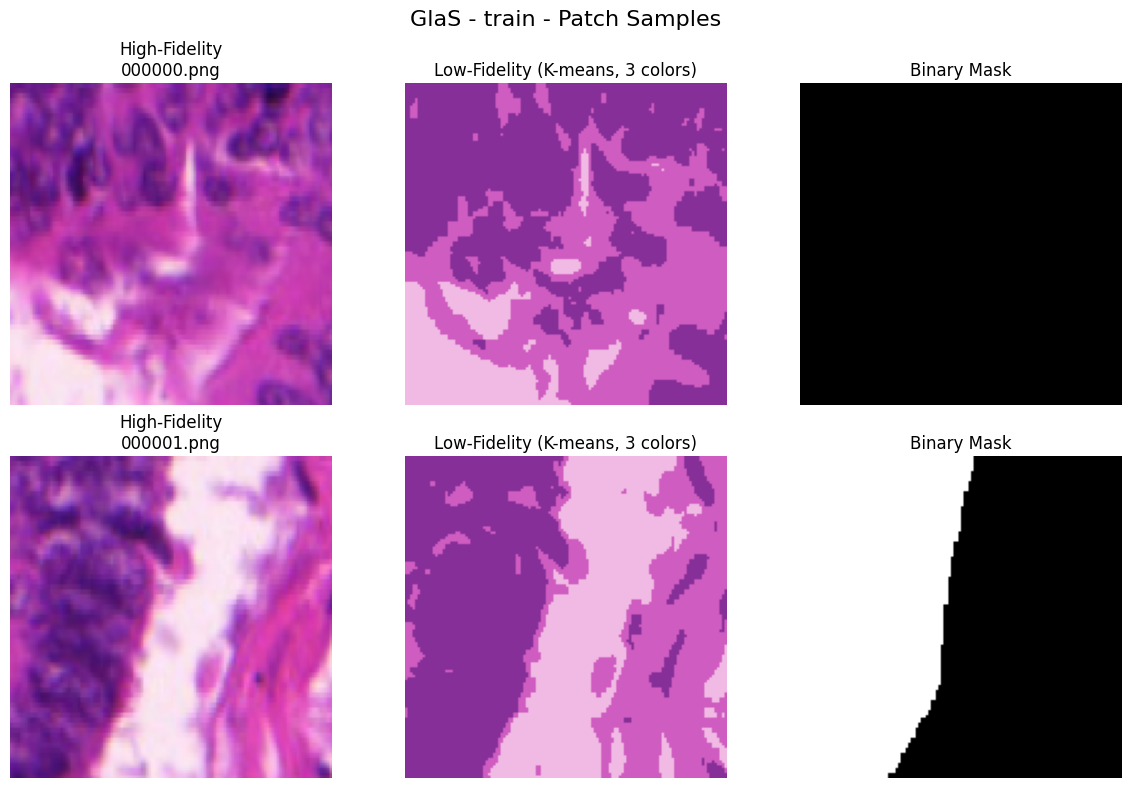

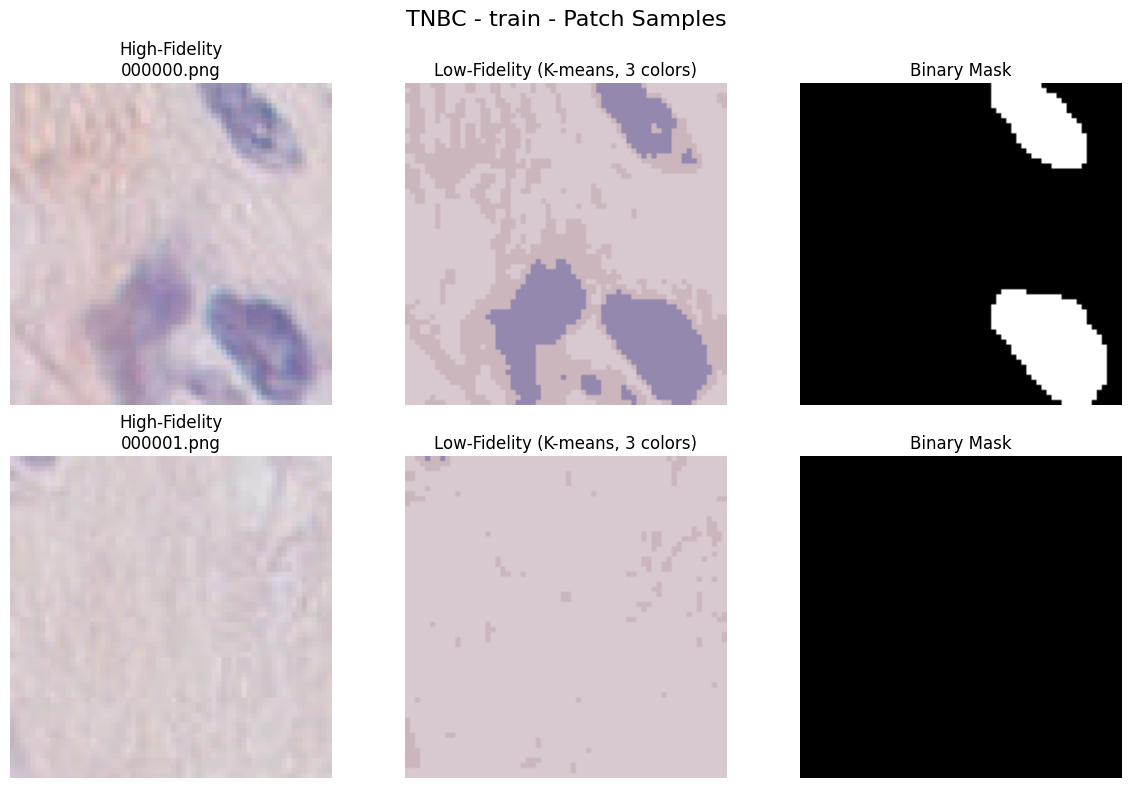

In [19]:
def visualize_patches(dataset_name, split, num_samples=3):
    """Visualize high-fidelity, low-fidelity, and mask patches."""
    high_dir = PATCHES_DIR / f'{dataset_name}_{split}_high'
    low_dir = PATCHES_DIR / f'{dataset_name}_{split}_low'
    mask_dir = PATCHES_DIR / f'{dataset_name}_{split}_mask'
    
    patch_files = sorted(list(high_dir.glob('*.png')))[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, patch_path in enumerate(patch_files):
        # Load patches
        high = cv2.imread(str(patch_path), cv2.IMREAD_COLOR)
        high = cv2.cvtColor(high, cv2.COLOR_BGR2RGB)
        
        low = cv2.imread(str(low_dir / patch_path.name), cv2.IMREAD_COLOR)
        low = cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(str(mask_dir / patch_path.name), cv2.IMREAD_GRAYSCALE)
        
        # Display
        axes[idx, 0].imshow(high)
        axes[idx, 0].set_title(f'High-Fidelity\n{patch_path.name}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(low)
        axes[idx, 1].set_title(f'Low-Fidelity (K-means, 3 colors)')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(mask, cmap='gray')
        axes[idx, 2].set_title(f'Binary Mask')
        axes[idx, 2].axis('off')
    
    plt.suptitle(f'{dataset_name} - {split} - Patch Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize samples from each dataset
print("="*60)
print("PATCH VISUALIZATION")
print("="*60)

visualize_patches('MoNuSeg', 'train', num_samples=2)
visualize_patches('GlaS', 'train', num_samples=2)
visualize_patches('TNBC', 'train', num_samples=2)